<a href="https://colab.research.google.com/github/Rafaelg16/git-github.ap/blob/main/An%C3%A1lise_Log%C3%ADstica_Atividade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Visualização: Para começar carregamos o dataset contendo latitude, longitude e price, foi carregado utilizando a biblioteca pandas.

In [4]:
import pandas as pd

geo_data = pd.read_csv('Fiap On - Fase 6 - Geolocalização Dataset - Asset.csv', usecols = ['longitude', 'latitude', 'price'])
geo_data.head()

,latitude,longitude,price
0,"-21,591360","-51,066690","52,47"
1,"-21,285350","-49,654970","37,03"
2,"-22,025900","-47,067020","71,50"
3,"-21,916230","-46,686660","88,27"
4,"-22,476390","-46,632780","36,16"


In [ ]:
# Tratamento de tipos de Dados: As colunas foram analisadas e percebemos que era necessário converter as colunas de texto(string) para números(float),
# fazendo assim a substituição de vírgulas (,) por pontos (.) para garantir o formato numérico correto para análise.

In [5]:
# Mudando de string para float
geo_data['latitude'] = geo_data['latitude'].astype(str).str.replace(',','.', regex=False). astype(float)
geo_data['longitude'] = geo_data['longitude'].astype(str).str.replace(',','.', regex=False). astype(float)
geo_data['price'] = geo_data['price'].astype(str).str.replace(',','.', regex=False). astype(float)

In [ ]:
# Separação/Normalização/Escalonamento dos Dados: O algoritmo  K-means usa a distância Euclidiana para "juntar" os pontos. Logo como a escala entre latitude e longitude é
# parecida, no entanto a distância é uma métrica sencível à escala, por conta disso é fundamental normalizar os dados. A normalização visa garantir que ambas as dimensões
# (eixo x e y no mapa) contribuam de maneira igual para o cálculo da distância, evitando que uma dimensão sobressaia a outra.

In [6]:
# Normalização dos dados
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(geo_data[['latitude', 'longitude']], geo_data[['price']], test_size=0.33, random_state=0)
from sklearn import preprocessing

# Treinando as bases
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)
from sklearn.preprocessing import StandardScaler

# Vamos usar para aplicar escalonamento
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)

In [ ]:
# O algoritmo K-Means exige que o número de clusters(K) seja definido antecipadamente. Para isso vamos usar o método de Cotovelo.

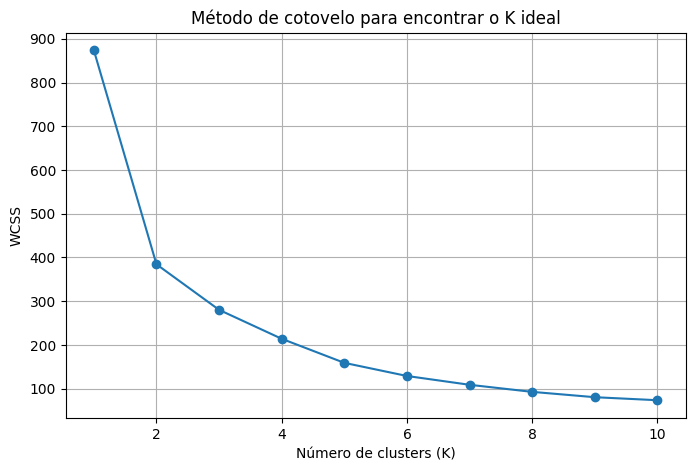

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
# Testa um intervalo de k (de 1 a 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_) # 'inertia_' é a WCSS

# Plotar o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método de cotovelo para encontrar o K ideal')
plt.xlabel('Número de clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [12]:
# Definindo K_IDEAL como um inteiro baseado na análise que fizemos acima.
K_IDEAL = 4

In [9]:
# Treinamento do K-Means final (usando a variável numérica)
kmeans_final = KMeans(n_clusters=K_IDEAL, init='k-means++', random_state=42, n_init='auto')
y_kmeans = kmeans_final.fit_predict(X_scaled)

# Adicionar os resultados do clustering ao DataFrame original
# Logo de início, precisamos garantir que o número de linhas em y_kmeans corresponde ao número de linhas em X_scaled.
# X_scaled foi criado a partir de X_train, que é uma parte de geo_data.
# Precisamos mapear os clusters de volta para o DataFrame geo_data.

# Um jeito seguro é adicionar os clusters de volta ao X_train (que foi usado para treinar o K-Means)
# e depois merge/join com o DataFrame original geo_data se for necessário para analisar.

# Logo, Criaremos um DataFrame temporário com os resultados do cluster e o índice original de X_train
X_train_df = pd.DataFrame(X_train, index=X_train.index)
X_train_df['cluster'] = y_kmeans

# Agora, podemos usar este DataFrame X_train_df para a análise de viabilidade
# ou juntá-lo de volta ao DataFrame geo_data se a análise envolver colunas que não estavam em X_train.

# Para a análise de viabilidade pedida na próxima célula, vamos adicionar a coluna 'cluster'
# diretamente ao DataFrame geo_data, certificando-nos de que os índices estão alinhados corretamente.
# Como X_train foi criado diretamente de geo_data com train_test_split,
# os índices de X_train correspondem aos índices das linhas correspondentes em geo_data.
geo_data['cluster'] = None # Vai iniciar a coluna cluster com none
geo_data.loc[X_train.index, 'cluster'] = y_kmeans # Atribui os clusters apenas para as linhas
# que estavam em X_train

# Exiba as primeiras linhas do DataFrame geo_data com a nova coluna 'cluster'
display(geo_data.head())

,latitude,longitude,price,cluster
0,-21.59136,-51.06669,52.47,1
1,-21.28535,-49.65497,37.03,None
2,-22.02590,-47.06702,71.50,3
3,-21.91623,-46.68666,88.27,3
4,-22.47639,-46.63278,36.16,0


In [10]:
# Centros de cluster na escala normalizada
centros_scaled = kmeans_final.cluster_centers_

# Inversão para obter as coordenadas reais (latitude e longitude)
centros_real = scaler.inverse_transform(centros_scaled)

# Exibição dos centros de cluster reais (Lat/Lon)
print("Localizações Propostas para os Centros (Lat/Lon e Valor Médio):")
print(centros_real)

Localizações Propostas para os Centros (Lat/Lon e Valor Médio):
[[-23.3242492  -46.91811867]
 [-20.80316051 -50.34786653]
 [-22.3851267  -50.1152699 ]
 [-21.22281891 -47.97196978]]


In [11]:
# Agrupamento para calcular o valor total e o volume de falhas por cluster
analise_viabilidade = geo_data.groupby('cluster').agg(
    total_entregas=('price', 'count'), # Corrigido 'valor_entrega' para 'price'
    valor_total_entregas=('price', 'sum') # Corrigido 'valor_entrega' para 'price'
).reset_index()

print("\nAnálise de Viabilidade por cluster:")
print(analise_viabilidade)


Análise de Viabilidade por cluster:
   cluster  total_entregas  valor_total_entregas
0        0             150               9766.74
1        1              98               6240.80
2        2              97               5994.73
3        3              92               5994.86


In [ ]:
# Conclusão: A análise nos mostra que o Cluster 0, é o mais importante do ponto de vista financeiro e logístico, pois concentra o maior volume de entregas(150) e o
# maior valor(9776.74). Os outros centros apresentam um volume de demanda e valor um pouco mais equilibrado.

In [ ]:
# Justificativa Técnica: Escolhemos o Algoritmo K-Means por ser simples, rápido e eficaz para grandes conjuntos de dados e geometrias esféricas(o que é esperado para a distribuição de coordenadas geográficas).
# Método do Cotovelo(WCSS): Propõe um equilíbrio entre a coesão interna dos clusters(baixa WCSS) e a parcimÔnia(menor númerode clusters).
# Normalização(StandardScaler): Garante que a métrica de distância(usada pelo K-Means) não seja dominada por nenhuma variável, resultando assim em clusters geograficamente mais confiáveis.
# Viabilidade: Os quatro clusters são viáveis, já que cada um atende a um volume significativo de entregas. O cluster 0 é de maior prioridade para implantação.